In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [13]:
#viral dynamics model parameters
drugtype = 'RTI' #antiviral
CL = 2.3
lambdaT = 2e9
deltaT = 0.02
Tu = lambdaT/deltaT
deltaPIC = 0.35
deltaT1 = 0.02
deltaT2 = 1
beta = 8e-12
k = 0.35
NT = 670

#pharmacodynamic parameters
IC50 = 10.7
m = 1.69
D = IC50 #drug concentration

In [14]:
#Functions for analytical solution
def eta(D):
    if D < 0: p = 0
    else: p = D**m/(IC50**m + D**m)
    return p

def PE(dType,X,D):
    '''
    Calculate the extinction probability for 
    dType = drug type, either RTI or absence of any drug
    X = initial state of the system
    D = drug concentration
    '''
    if dType == 'RTI':
        P_VT1 = (1-eta(D))*beta*Tu/((1-eta(D))*beta*Tu+CL+(1 + eta(D))*beta*Tu)
        P_T1T2 = k/(deltaPIC+deltaT1+k)
        R0 = P_VT1*P_T1T2*NT/deltaT2   
    else:
        P_VT1= beta*Tu/((beta*Tu)+(CL + beta*Tu))
        P_T1T2 = k/(deltaPIC+deltaT1+k)
        R0 = P_VT1*P_T1T2*NT/deltaT2
    
    res_V = min(1,1-P_VT1*P_T1T2*(1-1/R0))
    res_T1 = min(1,1-P_T1T2*(1-1/R0))
    res_T2 = min(1,1/R0)
    log_res = X[0]*np.log(res_V) + X[1]*np.log(res_T1) + X[2]*np.log(res_T2)
    return np.exp(log_res)

def anaSol(VL,D):    
    Y = [VL,0,0] #
    pe = PE(drugtype,Y,D)
    return pe

# Functions for Extrande simulations
        
def betaT(D):
    return beta*(1-eta(D))
                
def CLT(D):
    return (1 + eta(D))*beta

def A(X,D,t):
    a = np.array([(CL + CLT(D)*Tu)*X[0],(deltaPIC+deltaT1)*X[1],deltaT2*X[2],
                  (1-eta(D))*beta*Tu*X[0],k*X[1],NT*X[2]])
    return a

def choose(vec,a0tau2):
    i = 0
    while(i < len(vec)):
        if np.sum(vec[:i]) < a0tau2 <= np.sum(vec[:i+1]):
            return i
        i+=1
    return i

def Extrande(Y,t0,tfinal):
    '''
    Compute infection/extinction probabilities for
        Y = initial state of the system
        t0 = initial time of the system
        tfinal = final time where the simulation stops
    
    return env
        env = integer indicates the resulting event
            -1: intial value (None)
            0: extinction 
            1: infection
            2: latently infected cells
            3: time exceeds final time of the system
            4: number of runs exceed maximal number of runs (error)
    '''
    count = 0; maxcount = 50000 #initial counter; maximal number of simulations
    ev = -1 #specifies the resulting event of the system
    t = t0 
    while (t < tfinal) & (count < maxcount):
        count += 1
        if count >= maxcount:
            ev = 4
            print('limit for counts exceeded, time = ',t)
        # Determine upper bound for the sum of the reaction propensities
        bx = A(Y,0,t) #reaction propensities in absence of antivirals
        B = np.sum(bx) #sum of the reaction propensities
        r1 = random.uniform(0,1) #sample from a uniform distribution
        tau = 1/B*np.log(1/r1) #transform to an exponential distribution
        t = t + tau #update time
        if t  >= tfinal:
            ev = 3
            break 
        ax = A(Y,D,t)
        a0 = np.sum(ax)
        r2 = random.uniform(0,1)
        if a0 > B * r2: # A reaction fires changing the state
            j = choose(ax,B*r2) #Choose the reaction
            if (j == 3) | (j == 4):
                r3 = random.uniform(0,1)
                br = False #break variable
                if (j == 3) & (r3 <= 1.25e-4): br = True
                if (j == 4) & (r3 <= 8e-6): br = True
                if br:
                    #print('long lived latently infected cell, count = ',count)
                    ev = 2
                    break                    
            Y += v[:,j] #update state of the system
            if (Y[0] == 0) & (Y[1] == 0) & (Y[2] == 0): #all viral comopartments = 0
                ev = 0
                #print('Extinction event')
                #print('count = ',count)
                break            
            
            else:
                if PE(drugtype,Y,D) < epsilon: #extinction probability smaller than threshold
                    #print('Infection event')
                    ev = 1
                    break
            
        #else: # The trajectory at time t is within the extinction simplex
            #print('rejection step! count = ',count)
    
    return ev

In [15]:
#Number of simulations
numSim = [10, 50, 100, 200, 500]

# Initialization
VL = 10 #initial viral load
Y0 = [VL,0,0]
Y = Y0 #initial state
t0 = 0; tfinal = 24 #initial and final time of the system

# Computation with Extrande
epsilon = 0.0001 #user-defined threshold

# stoichiometric matrix vij
Ncols = 6; Nrows = 3
v = np.zeros((Nrows,Ncols),dtype = int)
v[0][0] = -1; v[0][3] = -1; v[0][5] = 1
v[1][1] = -1; v[1][3] = 1; v[1][4] = -1
v[2][2] = -1; v[2][4] = 1; v[2][5] = 0

xList = []; ExtList = []; ymean = []; yerr = []
for nn in range(len(numSim)):
    errList = []
    n = numSim[nn] #number of simulations
    for kk in range(10):
        xList.append(numSim[nn])
        res = [0,0,0,0,0,0] #each position specifies an event of Extrande
        for ii in range(n):
            jj = Extrande(Y,t0,tfinal) #jj integer, specifies the calculated event
            res[jj+1] += 1 #offset 1
        expro = res[1]/n #extinction probability
        errList.append(expro)
        ExtList.append(expro) 
    ymean.append(np.mean(errList))
    yerr.append(np.std(errList))


# Compute analytical solution
aSol = anaSol(VL,D)
aSolList = []
for i in range(len(numSim)):
    aSolList.append(aSol)


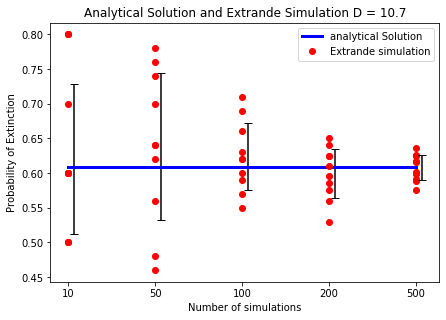

In [29]:
#plot results
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9]) # main axes 
ax.plot(numSim,aSolList,'b-',linewidth = 3,label = 'analytical Solution') 
ax.set_xlabel('Number of simulations')   
ax.set_ylabel('Probability of Extinction')     
ax.set_xticks([10,132.5,255,377.5,500])
yList = [18,141,263,386,508]
#ayList = np.asarray(yList)

for i in range(len(xList)):
    if xList[i] == 50: xList[i] = 132.5
    if xList[i] == 100: xList[i] = 255
    if xList[i] == 200: xList[i] = 377.5
ax.set_xticklabels(['10','50','100','200','500'])
#ax.set_yticks([0,0.5,1])
for i in range(len(xList)):
    ax.plot(xList[i],ExtList[i],'ro') 

(_,caps,_) = plt.errorbar(yList,ymean,yerr,color='black',fmt=' ',markersize=8,capsize=4)

for cap in caps:
    cap.set_markeredgewidth(1)
    
ax.plot(xList[0],ExtList[0],'ro',label = 'Extrande simulation')     
ax.set_title('Analytical Solution and Extrande Simulation D = '+str(D))  
plt.legend(loc='best')  
plt.show()